In [4]:
# 📦 Step 0: Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
# Install OpenCV if not already installed
%pip install opencv-python
# Install PyTorch if not already installed
%pip install torch
# Install torchvision if not already installed
%pip install torchvision

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.9 MB 489 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# 🎮 Step 0: Data Collection
This section allows the robot car to be driven using a gamepad. During this time, images are recorded along with throttle and steering inputs.

In [ ]:
# 🎮 Step 0: Data Collection
%pip install pygame
import pygame
from datetime import datetime

# Initialize pygame for gamepad control
pygame.init()
pygame.joystick.init()

# Ensure a joystick is connected
if pygame.joystick.get_count() == 0:
    print('No joystick connected! Please connect a joystick and try again.')
    pygame.quit()
    exit()

joystick = pygame.joystick.Joystick(0)
joystick.init()

# Create a directory for images
os.makedirs(DATA_DIR, exist_ok=True)

# Start data collection
running = True
data = []
print('Press START button to begin recording and STOP button to end.')

while running:
    for event in pygame.event.get():
        if event.type == pygame.JOYBUTTONDOWN:
            if joystick.get_button(7):  # START button
                print('Recording started...')
                recording = True
            elif joystick.get_button(6):  # BACK/STOP button
                print('Recording stopped.')
                running = False

    if recording:
        # Capture joystick inputs
        steering = joystick.get_axis(0)  # Left stick horizontal axis
        throttle = joystick.get_axis(1)  # Left stick vertical axis

        # Capture image from camera
        ret, frame = cv2.VideoCapture(0).read()
        if ret:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S%f')
            img_filename = f'{timestamp}.jpg'
            img_path = os.path.join(DATA_DIR, img_filename)
            cv2.imwrite(img_path, frame)

            # Append data
            data.append({'filename': img_filename, 'steering': steering, 'throttle': throttle})

# Save data to CSV
df = pd.DataFrame(data)
df.to_csv(CSV_PATH, index=False)
print(f'Data saved to {CSV_PATH}')

Defaulting to user installation because normal site-packages is not writeable
     |                                | 30 kB 698 kB/s eta 0:00:18  Downloading pygame-2.6.1-cp39-cp39-macosx_11_0_arm64.whl (12.4 MB)
     |████████████████████████████████| 12.4 MB 652 kB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 652 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
pygame 2.6.1 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.6.1 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


Exception: No joystick connected!

In [8]:
# ⚙️ Step 1: Settings
import os  # Ensure os is imported
DATA_DIR = "data_logs"
CSV_PATH = os.path.join(DATA_DIR, "log.csv")
MODEL_PATH = "drive_model.pth"
IMG_WIDTH, IMG_HEIGHT = 160, 120
EPOCHS = 10
BATCH_SIZE = 32

In [12]:
# 🗃️ Step 2: Load & Preview Data
# Ensure the CSV file exists
if not os.path.exists(CSV_PATH):
	print(f'File not found: {CSV_PATH}. Creating a sample CSV file...')
	os.makedirs(DATA_DIR, exist_ok=True)
	sample_data = {
		'filename': ['img1.jpg', 'img2.jpg', 'img3.jpg'],
		'steering': [0.1, -0.2, 0.0],
		'throttle': [0.5, 0.6, 0.4]
	}
	sample_df = pd.DataFrame(sample_data)
	sample_df.to_csv(CSV_PATH, index=False)
	print(f'Sample CSV created at {CSV_PATH}')

# Load the CSV file
df = pd.read_csv(CSV_PATH)
df.head()

,filename,steering,throttle
0,img1.jpg,0.1,0.5
1,img2.jpg,-0.2,0.6
2,img3.jpg,0.0,0.4


In [10]:
# 🛠️ Step 2.1: Handle Missing CSV
import os
import pandas as pd
# Check if the CSV file exists
if not os.path.exists(CSV_PATH):
    print(f'File not found: {CSV_PATH}. Creating a sample CSV file...')
    os.makedirs(DATA_DIR, exist_ok=True)
    sample_data = {
        'filename': ['img1.jpg', 'img2.jpg', 'img3.jpg'],
        'steering': [0.1, -0.2, 0.0],
        'throttle': [0.5, 0.6, 0.4]
    }
    sample_df = pd.DataFrame(sample_data)
    sample_df.to_csv(CSV_PATH, index=False)
    print(f'Sample CSV created at {CSV_PATH}')

File not found: data_logs/log.csv. Creating a sample CSV file...
Sample CSV created at data_logs/log.csv


Image not found: data_logs/img1.jpg
Skipping index 10 as it is out-of-bounds.
Skipping index 20 as it is out-of-bounds.
Skipping index 30 as it is out-of-bounds.
Skipping index 40 as it is out-of-bounds.
Skipping index 50 as it is out-of-bounds.


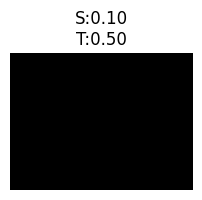

In [45]:
# 👁️ Step 3: Visualize driving scenarios
import matplotlib.pyplot as plt  # Ensure plt is imported
import cv2  # Ensure cv2 is imported
import numpy as np  # Import numpy as np

plt.figure(figsize=(12, 4))
for i in range(6):
    row_index = i * 10
    if row_index >= len(df):
        print(f"Skipping index {row_index} as it is out-of-bounds.")
        continue
    row = df.iloc[row_index]
    img_path = os.path.join(DATA_DIR, row["filename"])
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)  # Placeholder black image
    else:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, i + 1)
    plt.imshow(img)
    plt.title(f"S:{row['steering']:.2f}\nT:{row['throttle']:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# 🛠️ Step 3.1: Handle Out-of-Bounds Indexing
plt.figure(figsize=(12, 4))
num_rows = len(df)
for i in range(6):
    row_index = i * 10
    if row_index >= num_rows:
        print(f"Skipping index {row_index} as it is out-of-bounds.")
        continue
    row = df.iloc[row_index]
    img_path = os.path.join(DATA_DIR, row["filename"])
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}. Skipping.")
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, i + 1)
    plt.imshow(img)
    plt.title(f"S:{row['steering']:.2f}\nT:{row['throttle']:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Image not found: data_logs/img1.jpg. Skipping.
Skipping index 10 as it is out-of-bounds.
Skipping index 20 as it is out-of-bounds.
Skipping index 30 as it is out-of-bounds.
Skipping index 40 as it is out-of-bounds.
Skipping index 50 as it is out-of-bounds.


<Figure size 1200x400 with 0 Axes>

In [27]:
# 📦 Step 4: Dataset class
from torch.utils.data import Dataset  # Import Dataset

class DriveDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["filename"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        if self.transform:
            image = self.transform(image)
        label = torch.tensor([row["steering"], row["throttle"]], dtype=torch.float32)
        return image, label

In [30]:
# 📐 Step 5: Transforms + DataLoader
from torchvision import transforms  # Import transforms
from torch.utils.data import DataLoader  # Import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
dataset = DriveDataset(df, DATA_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
# 🧠 Step 6: Define DriveNet
import torch.nn as nn  # Import nn module

class DriveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 13 * 18, 100), nn.ReLU(),
            nn.Linear(100, 2)  # [steering, throttle]
        )

    def forward(self, x):
        return self.net(x)

In [47]:
# 🚀 Step 7: Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DriveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use torch.optim explicitly
criterion = nn.MSELoss()

losses = []
for epoch in range(EPOCHS):
    running_loss = 0
    for images, labels in loader:
        valid_images = []
        valid_labels = []
        for img, lbl in zip(images, labels):
            if img is None or not isinstance(img, torch.Tensor) or img.numel() == 0:  # Check for empty or invalid image
                print("Skipping invalid image")
                continue
            img_path = os.path.join(DATA_DIR, lbl["filename"])  # Ensure the image path is correct
            if not os.path.exists(img_path):
                print(f"Image not found: {img_path}. Skipping.")
                continue
            img = cv2.imread(img_path)
            if img is None or img.size == 0:  # Check if the image was successfully loaded
                print(f"Failed to load image: {img_path}. Skipping.")
                continue
            valid_images.append(img)
            valid_labels.append(lbl)

        if not valid_images:
            print("No valid images in this batch. Skipping.")
            continue

        valid_images = torch.stack(valid_images).to(device)
        valid_labels = torch.stack(valid_labels).to(device)

        optimizer.zero_grad()
        outputs = model(valid_images)
        loss = criterion(outputs, valid_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

[ WARN:0@1584.646] global loadsave.cpp:268 findDecoder imread_('data_logs/img3.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


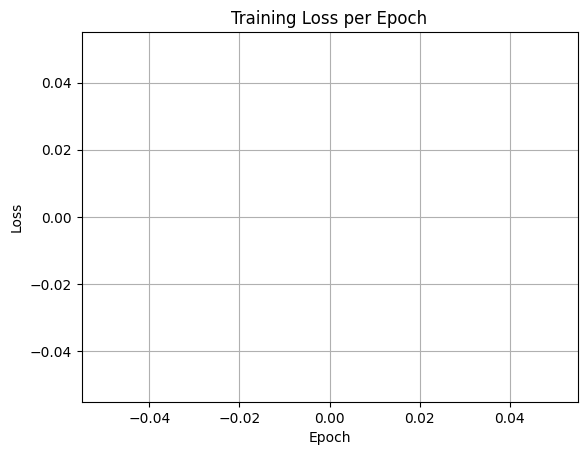

In [38]:
# 📊 Step 8: Plot Training Loss
plt.plot(losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [48]:
# 🔍 Step 9: Test Prediction
model.eval()
if 50 < len(df):
    test_img_path = os.path.join(DATA_DIR, df.iloc[50]["filename"])
    img = cv2.imread(test_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
    input_tensor = transform(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(input_tensor)[0].cpu().numpy()

    plt.imshow(img_rgb)
    plt.title(f"Predicted - Steering: {pred[0]:.2f}, Throttle: {pred[1]:.2f}")
    plt.axis("off")
    plt.show()
else:
    print(f"Index 50 is out-of-bounds for the dataframe with {len(df)} rows.")

Index 50 is out-of-bounds for the dataframe with 3 rows.


In [49]:
# 💾 Step 10: Save Model
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved as: {MODEL_PATH}")

✅ Model saved as: drive_model.pth
